<a href="https://colab.research.google.com/github/microprediction/winningnotebooks/blob/main/Luce_Axiom_LLMs_Variations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install winning
!pip install pandas
!pip install scipy

# Luce's Choice Axiom versus the Standard Normal Race model
The methodology is as follows.

1.   Ask an LLM to assign probabilities $p_i$ to a set A of tokens
2.   Ask an LLM to assign probabilities to a subset $B \subset A$ of tokens

We then try to predict the subset probabilities in two ways:

1.   A simple renormalization (Luce Choice Axiom):  $p_i/(\sum_{j\in B} p_j)$
2.   The Standard Normal Race model: Set $X_i \sim N(a_i,1)$ where $a_i$ are calibrated to the $p_i$ using the ability transform.  

We then compare the errors.




## A contest model for choice

Luce is trivial. Let's just implement the second here using the `winning` package:;

In [3]:
from winning.std_calibration import std_state_price_implied_ability, STD_UNIT, STD_L, STD_SCALE, std_ability_implied_state_prices
def ability_implied_subrace_probabilities(race:dict, runners:[str])-> dict:
     #   Subrace probabilities
     probs = list(race.values())
     names = list(race.keys())
     abilities = std_state_price_implied_ability(probs, unit=STD_UNIT, L=STD_L, scale=STD_SCALE)
     sub_names = [nm for nm in names if nm in runners]
     sub_abil = [a for nm, a in zip(names,abilities) if nm in runners]
     sub_prob = implied_probabilities = std_ability_implied_state_prices(ability=sub_abil,unit=STD_UNIT, L=STD_L, scale=STD_SCALE)
     implied = dict( zip(sub_names,sub_prob) )
     return implied


race = {'red':0.5,'green':0.3,'blue':0.2}

runners = ['green','red']
implied = ability_implied_subrace_probabilities(race,runners )
implied

{'red': 0.6169905666139499, 'green': 0.38396120015303187}

## Experimental Setup...

In [5]:
import torch
from transformers import BertTokenizer, BertForMaskedLM
import pandas as pd
import numpy as np
import itertools
import os
from huggingface_hub import login

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# Authenticate with Hugging Face Hub if token is available
hf_token = os.getenv("HF_TOKEN")
if hf_token:
    login(token=hf_token)

def fill_in_missing_word(sentence, exclude_words=None, top_k=20):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Find the index of the masked token
    mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

    # Get the model's predictions (logits)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits

    if exclude_words:
        # Get the IDs of the words to exclude
        exclude_ids = tokenizer.convert_tokens_to_ids(exclude_words)
        # Set their logits to a very low value
        logits[0, mask_token_index, exclude_ids] = -float('inf')

    # Apply softmax to get probabilities
    probs = torch.softmax(logits[0, mask_token_index], dim=-1)

    # Get the top_k predictions
    top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)

    # If there's only one mask token, adjust dimensions
    if top_k_indices.dim() == 2 and top_k_indices.size(0) == 1:
        top_k_indices = top_k_indices.squeeze(0)
        top_k_probs = top_k_probs.squeeze(0)

    top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_indices.tolist())
    top_k_probs = top_k_probs.tolist()

    # Store the top predictions in a dictionary
    predictions = dict(zip(top_k_tokens, top_k_probs))

    return predictions

def luce_check(sentence1, sentence2):
    # Get probabilities from both sentences
    probs1 = fill_in_missing_word(sentence1, top_k=100)
    probs2 = fill_in_missing_word(sentence2, top_k=10)

    # Filter out words in sentence2 not present in sentence1
    common_tokens = set(probs1.keys()).intersection(set(probs2.keys()))

    # Create filtered dictionaries with common tokens
    probs1_filtered = {token: probs1[token] for token in common_tokens}
    probs2_filtered = {token: probs2[token] for token in common_tokens}

    # Store the original scores (unnormalized) before renormalization
    original_scores = {token: probs1[token] for token in probs1_filtered}

    # Renormalize probs2 so they sum to 1
    total_prob2 = sum(probs2_filtered.values())
    probs2_normalized = {token: prob / total_prob2 for token, prob in probs2_filtered.items()}

    # Renormalize probs1 so they sum to 1
    total_prob1 = sum(probs1_filtered.values())
    probs1_normalized = {token: prob / total_prob1 for token, prob in probs1_filtered.items()}

    # Also add ability implied ...
    prob2_ability = ability_implied_subrace_probabilities(race=probs1, runners=common_tokens)


    # Merge both into a DataFrame for comparison
    df = pd.DataFrame({
        'Choice': list(probs1_normalized.keys()),
        'Original score': [original_scores[token] for token in probs1_normalized.keys()],
        'Luce score': list(probs1_normalized.values()),
        'Ability score': [ prob2_ability[token] for token in probs1_normalized.keys()],
        'Actual score': [probs2_normalized[token] for token in probs1_normalized.keys()]
    })

    # Add a column for the empirical / Luce ratio
    df['Actual/Luce'] = df['Actual score'] / df['Luce score']
    df['Actual/Ability'] = df['Actual score'] / df['Ability score']
    df['Ability RMSE'] =  np.sqrt(((df['Actual score'] - df['Ability score']) ** 2).mean())
    df['Luce RMSE'] =  np.sqrt(((df['Actual score'] - df['Luce score']) ** 2).mean())
    winner = 0 if df['Luce RMSE'].loc[0]<df['Ability RMSE'].loc[0] else 1
    df['Winner'] = winner

    df.sort_values('Luce score',inplace=True, ascending=False)

    return df


# Function to generate all sentence variations based on brackets while preserving [MASK]
def generate_variations(sentence_template):
    parts = sentence_template.split('[')
    variations = ['']
    for part in parts:
        if ']' in part:
            options, rest = part.split(']', 1)
            options = options.split('|')
            variations = [v + option + rest for v in variations for option in options]
        else:
            variations = [v + part for v in variations]

    # Ensure [MASK] remains intact
    variations = [v.replace('MASK', '[MASK]') for v in variations]
    return variations

# Function to remove optional clauses in angle brackets
def remove_angle_brackets(sentence_template):
    while '<' in sentence_template and '>' in sentence_template:
        start = sentence_template.index('<')
        end = sentence_template.index('>') + 1
        sentence_template = sentence_template[:start] + sentence_template[end:]
    return sentence_template

# Function to generate angle bracket variations
def generate_angle_variations(sentence_template):
    parts = sentence_template.split('<')
    variations = ['']
    for part in parts:
        if '>' in part:
            options, rest = part.split('>', 1)
            options = options.split('|')
            variations = [v + option + rest for v in variations for option in options]
        else:
            variations = [v + part for v in variations]
    return variations

# Function to run the Luce check for all aligned variations and concatenate results
def run_luce_analysis_aligned(sentence_templates:[str]):
    all_results = []
    for sentence_template in sentence_templates:
        sentence_variations = generate_variations(sentence_template)

        for sentence1 in sentence_variations:
            sentence1_no_brackets = remove_angle_brackets(sentence1)
            sentence2_variations = generate_angle_variations(sentence1)

            for sentence2 in sentence2_variations:
                print(sentence2)
                df = luce_check(sentence1_no_brackets, sentence2)
                if not df.empty:
                    df['Question Pair'] = f"{sentence1_no_brackets} | {sentence2}"
                    all_results.append(df)
                    print(df)

    # Concatenate all results into a single DataFrame
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
    else:
        final_df = pd.DataFrame()

    return final_df




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_entropy_vs_rmse_difference(df):
    """
    This function takes the DataFrame output of your program, computes the entropy for each question pair,
    and generates a scatter plot of entropy on the x-axis against the log of the RMSE of Luce minus log of RMSE of Ability.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the results of the Luce analysis.

    Returns:
    None: Displays a scatter plot.
    """
    # Initialize lists to store entropy and RMSE differences
    entropies = []
    rmse_log_diffs = []
    question_pairs = []

    # Group by 'Question Pair'
    grouped = df.groupby('Question Pair')

    for question_pair, group in grouped:
        # Get the 'Actual score' probabilities
        actual_scores = group['Actual score'].values
        # Ensure that the probabilities sum to 1
        actual_scores = actual_scores / actual_scores.sum()
        # Compute entropy
        entropy = -np.sum(actual_scores * np.log(actual_scores + 1e-10))  # Add small value to avoid log(0)
        # Get the RMSE values (they should be the same for all rows in the group)
        luce_rmse = group['Luce RMSE'].iloc[0]
        ability_rmse = group['Ability RMSE'].iloc[0]
        # Handle cases where RMSE might be zero or negative
        if luce_rmse <= 0 or ability_rmse <= 0:
            continue  # Skip this group
        # Compute log difference
        rmse_log_diff = np.log(luce_rmse) - np.log(ability_rmse)
        # Append to lists
        entropies.append(entropy)
        rmse_log_diffs.append(rmse_log_diff)
        question_pairs.append(question_pair)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(entropies, rmse_log_diffs)
    plt.xlabel('Entropy of Actual Score Distribution')
    plt.ylabel('log(Luce RMSE) - log(Ability RMSE)')
    plt.title('Entropy vs. Log Difference of RMSEs')
    plt.grid(True)
    plt.show()

    # Optionally, return the data used for plotting
    return pd.DataFrame({
        'Question Pair': question_pairs,
        'Entropy': entropies,
        'RMSE Log Difference': rmse_log_diffs
    })


In [7]:
sentence_templates_1 = [ "My favourite <Western|Eastern|Northern|Southern> state in the [U.S.|U.K.] is [MASK] and I try to visit once a year.",
                      f"The <infectious|old age|hereditary|deficiency|physiological> disease I fear most is known as {tokenizer.mask_token} and my uncle got it.",
                       f"My favourite type of <citrus|stone|tropical> fruit is called a {tokenizer.mask_token} and I eat one of them every day.",
                       f"My favourite <alcoholic|caffienated> drink is called {tokenizer.mask_token} and I drink it when I can",
                       f"My favorite <farm|> animal is called a {tokenizer.mask_token} and I like them a lot.",
                       f"My favorite <predatory|waterfowl|wading|song|sea> bird is a {tokenizer.mask_token} and I like to watch them.",
                       f"My preferred mode of <public|private> transportation is called {tokenizer.mask_token} and it takes me from A to B.",
                       f"My favourite <U.K.|American|Japanese> car brand is called {tokenizer.mask_token} and they make a lot of cars",
                       f"The <winter|summer> sport that draws the biggest crowds is called {tokenizer.mask_token}, and it is fun to go and watch.",
                       f"My favourite <object-oriented|classic|low-level> programming language is called {tokenizer.mask_token} and I write programs with it all the time.",
                       f"I like to drink <hot|cold> {tokenizer.mask_token} in the morning or the evening.",
                       f"My preferred <small|reptilian> pet is a {tokenizer.mask_token}, they make great companions.",
                       f"My favorite <girl's|boys's> baby name is {tokenizer.mask_token}, and I always associate it with family.",
                       f"My favorite age for <middle school|elementary school|high scho kids is {tokenizer.mask_token}, and my daughter is that age"
                       ]


sentence_templates_2 = [
    f"My favourite <classical|rock|jazz|pop|hip-hop> musician's last name is {tokenizer.mask_token}, and I listen to them every day.",
    f"I love to eat <Italian|Chinese|Mexican|Indian|Thai> food, and my favourite dish is called {tokenizer.mask_token}.",
    f"The <morning|afternoon|evening|night> exercise I enjoy most is called {tokenizer.mask_token}, and it helps me feel good.",
      f"I enjoy watching <comedy|drama|horror|action|animated> movies; my favorite character is named {tokenizer.mask_token} and [he|she] is great.",
    f"The <positive|negative|neutral> emotion I feel most often is {tokenizer.mask_token}; it affects my daily life.",
       f"My favourite <domestic|international> one word airline is called {tokenizer.mask_token}; they provide great service.",
        f"My favourite <string|wind|percussion|keyboard> instrument is the {tokenizer.mask_token}; I love its sound.",
    f"My favourite <indoor|outdoor> hobby is {tokenizer.mask_token}; I spend a lot of time on it.",
    f"My favourite <European|Asian|African|American> capital city is {tokenizer.mask_token}; I would love to visit.",
      f"My favourite <classic|modern> painter's name is {tokenizer.mask_token} and [he|she] is a genious.",
    f"I like to drive <compact|sedan|SUV|electric> cars. My favourite brand is called {tokenizer.mask_token} and they are [comfortable|fast|safe].",
    f"I enjoy <team|individual> sports. My favourite is called {tokenizer.mask_token} and it's [exciting|relaxing|] to play.",
         f"My preferred <wired|wireless> headphone brand is called {tokenizer.mask_token}; they have great sound quality.",
    f"The <domestic|international> news channel I watch is called {tokenizer.mask_token}; they provide reliable information.",
    f"I prefer <vegetarian|non-vegetarian|vegan|pescatarian> dishes. My favourite dish is called {tokenizer.mask_token}, and it is [delicious|healthy|unhealthy but tasty]",
   f"My favourite <fiction|non-fiction|poetry|drama> author's name is {tokenizer.mask_token}, I read all their books.",
    f"I enjoy <kids|adult> board games. My favourite is called {tokenizer.mask_token}, and it is fun.",
     f"My favorite <US|European|Asian|African> historical figure's name is {tokenizer.mask_token}; they changed the world.",
    f"My favourite type of <small|large|medium> dog breed is called {tokenizer.mask_token}; they make great pets.",
    f"I like <classical|modern|abstract|realism> art; my favorite artist's name is {tokenizer.mask_token}.",
    f"My favorite <city|country|beach|mountain> vacation city is called {tokenizer.mask_token}; I go there often.",
       f"I love <baking|cooking|grilling|frying> dishes. My favourite is called {tokenizer.mask_token}; it's my specialty.",
    f"My favourite <local|international> cuisine is called {tokenizer.mask_token}; it's incredibly flavorful.",
    f"I like to exercise <indoors|outdoors>. My favourite exercise is called {tokenizer.mask_token}; it keeps me fit.",
    f"I love <spring|summer|autumn|winter> festivals. My favourite is called {tokenizer.mask_token} and it was so much fun",
    f"My favorite <desktop|laptop|tablet|smartphone> brand is called {tokenizer.mask_token}; they make reliable devices.",
    f"My favourite <local|international> charity is called {tokenizer.mask_token}; I support their cause." ]

sentence_templates = sentence_templates_1 + sentence_templates_2

final_results = run_luce_analysis_aligned(sentence_templates)
print(f"The Standard Normal Race beats Luce Choice Axiom {int(final_results['Winner'].mean()*100)}% of the time")


Streaming output truncated to the last 5000 lines.
1  schizophrenia        0.007125    0.010994       0.014334      0.040115   

   Actual/Luce  Actual/Ability  Ability RMSE  Luce RMSE  Winner  \
8     1.575262        1.695133       0.08181   0.079396       0   
6     0.285846        0.296629       0.08181   0.079396       0   
7     0.324097        0.325795       0.08181   0.079396       0   
0     0.725243        0.718791       0.08181   0.079396       0   
4     0.656108        0.628491       0.08181   0.079396       0   
2     0.853433        0.804075       0.08181   0.079396       0   
3     2.704204        2.412806       0.08181   0.079396       0   
9     1.265283        1.117522       0.08181   0.079396       0   
5     3.685951        2.831199       0.08181   0.079396       0   
1     3.648731        2.798671       0.08181   0.079396       0   

                                       Question Pair  
8  The  disease I fear most is known as [MASK] an...  
6  The  disease I fear 

The Standard Normal Race beats Luce Choice Axiom 81% of the time
Total inferred probabilities: 1541


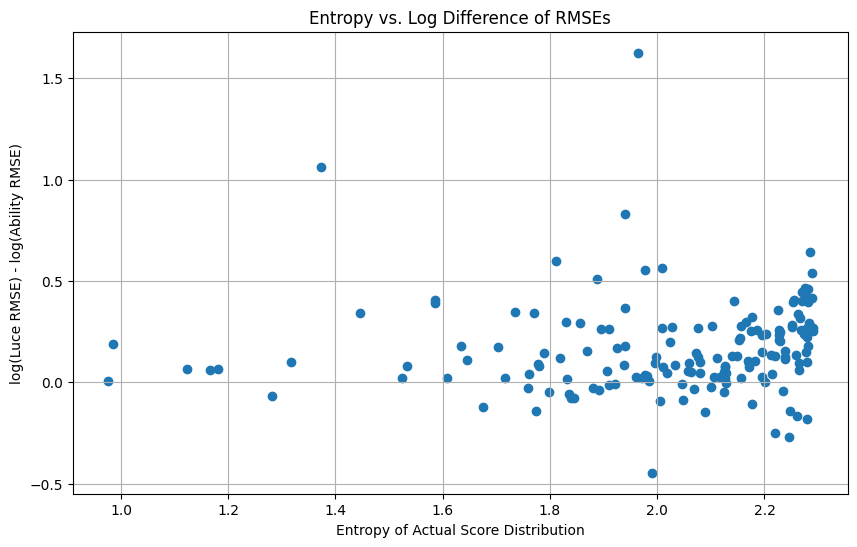

,Question Pair,Entropy,RMSE Log Difference
0,I enjoy board games. My favourite is called [...,1.940222,0.830599
1,I enjoy board games. My favourite is called [...,1.965021,1.625422
2,I enjoy sports. My favourite is called [MASK]...,2.004615,-0.090164
3,I enjoy sports. My favourite is called [MASK]...,1.836406,-0.058808
4,I enjoy sports. My favourite is called [MASK]...,2.127174,0.021636
...,...,...,...
157,"The exercise I enjoy most is called [MASK], a...",1.961176,0.027207
158,The news channel I watch is called [MASK]; th...,1.810741,0.600255
159,The news channel I watch is called [MASK]; th...,1.939415,0.364473
160,The sport that draws the biggest crowds is ca...,2.023026,0.199034


In [ ]:
print(f"The Standard Normal Race beats Luce Choice Axiom {int(final_results['Winner'].mean()*100)}% of the time")
print(f"Total inferred probabilities: {len(final_results)}")
plot_entropy_vs_rmse_difference(final_results)

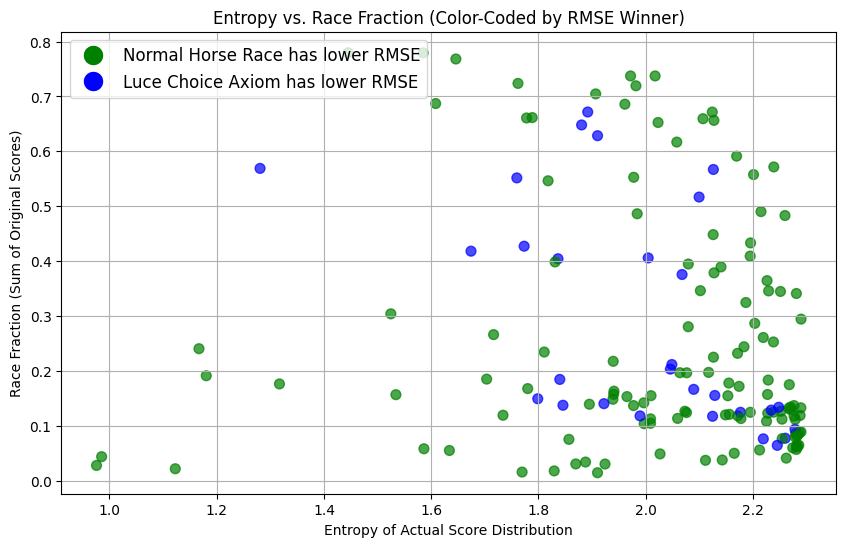

,Question Pair,Entropy,Race Fraction,Color
0,I enjoy board games. My favourite is called [...,1.940221,0.157261,green
1,I enjoy board games. My favourite is called [...,1.965021,0.153092,green
2,I enjoy sports. My favourite is called [MASK]...,2.004615,0.405781,blue
3,I enjoy sports. My favourite is called [MASK]...,1.836407,0.404291,blue
4,I enjoy sports. My favourite is called [MASK]...,2.127175,0.656373,green
...,...,...,...,...
153,"The exercise I enjoy most is called [MASK], a...",1.961174,0.685864,green
154,The news channel I watch is called [MASK]; th...,1.810741,0.234298,green
155,The news channel I watch is called [MASK]; th...,1.939413,0.217410,green
156,The sport that draws the biggest crowds is ca...,2.023026,0.652524,green


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_entropy_vs_race_fraction(df):
    """
    This function generates a scatter plot of race entropy vs. race fraction,
    color-coded by which model has the lower RMSE.

    Args:
    df (pd.DataFrame): DataFrame containing the columns 'Question Pair', 'Actual score',
                       'Luce RMSE', 'Ability RMSE', and 'Original score'.

    Returns:
    pd.DataFrame: A DataFrame containing the question pair, entropy, race fraction, and color used for plotting.
    """
    # Initialize lists to store entropy, race fractions, colors, and question pairs
    entropies = []
    race_fractions = []
    colors = []
    question_pairs = []

    # Group by 'Question Pair'
    grouped = df.groupby('Question Pair')

    for question_pair, group in grouped:
        # Get the 'Actual score' probabilities
        actual_scores = group['Actual score'].values
        # Ensure that the probabilities sum to 1
        actual_scores = actual_scores / actual_scores.sum()
        # Compute entropy
        entropy = -np.sum(actual_scores * np.log(actual_scores + 1e-10))  # Add small value to avoid log(0)
        # Compute race fraction (sum of 'Original score' column)
        race_fraction = group['Original score'].sum()
        # Get the RMSE values (they should be the same for all rows in the group)
        luce_rmse = group['Luce RMSE'].iloc[0]
        ability_rmse = group['Ability RMSE'].iloc[0]
        # Determine color based on which RMSE is lower
        color = 'green' if ability_rmse < luce_rmse else 'blue'
        # Append to lists
        entropies.append(entropy)
        race_fractions.append(race_fraction)
        colors.append(color)
        question_pairs.append(question_pair)

    # Create scatter plot of Entropy vs Race Fraction
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(entropies, race_fractions, color=colors, s=50, alpha=0.7)

    # Add legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15, label='Normal Horse Race has lower RMSE'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, label='Luce Choice Axiom has lower RMSE')
    ]
    plt.legend(handles=handles, loc='upper left', fontsize=12)

    # Axis labels and title
    plt.xlabel('Entropy of Actual Score Distribution')
    plt.ylabel('Race Fraction (Sum of Original Scores)')
    plt.title('Entropy vs. Race Fraction (Color-Coded by RMSE Winner)')
    plt.grid(True)
    plt.show()

    # Optionally, return the data used for plotting
    return pd.DataFrame({
        'Question Pair': question_pairs,
        'Entropy': entropies,
        'Race Fraction': race_fractions,
        'Color': colors
    })

# Example usage
# plot_entropy_vs_race_fraction(df)

# Example usage
plot_entropy_vs_race_fraction(final_results)


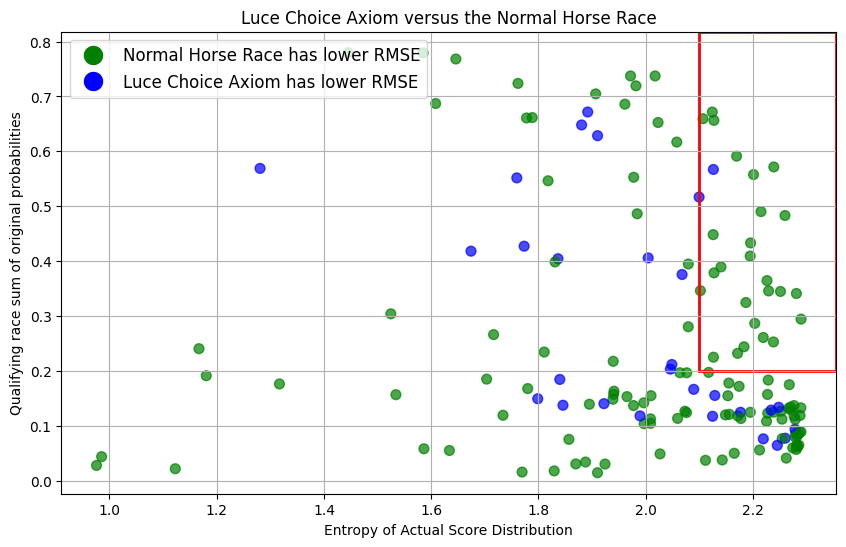

,Question Pair,Entropy,Race Fraction,Color
0,I enjoy board games. My favourite is called [...,1.940221,0.157261,green
1,I enjoy board games. My favourite is called [...,1.965021,0.153092,green
2,I enjoy sports. My favourite is called [MASK]...,2.004615,0.405781,blue
3,I enjoy sports. My favourite is called [MASK]...,1.836407,0.404291,blue
4,I enjoy sports. My favourite is called [MASK]...,2.127175,0.656373,green
...,...,...,...,...
153,"The exercise I enjoy most is called [MASK], a...",1.961174,0.685864,green
154,The news channel I watch is called [MASK]; th...,1.810741,0.234298,green
155,The news channel I watch is called [MASK]; th...,1.939413,0.217410,green
156,The sport that draws the biggest crowds is ca...,2.023026,0.652524,green


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_entropy_vs_race_fraction(df):
    """
    This function generates a scatter plot of race entropy vs. race fraction,
    color-coded by which model has the lower RMSE, and highlights a specific region.

    Args:
    df (pd.DataFrame): DataFrame containing the columns 'Question Pair', 'Actual score',
                       'Luce RMSE', 'Ability RMSE', and 'Original score'.

    Returns:
    pd.DataFrame: A DataFrame containing the question pair, entropy, race fraction, and color used for plotting.
    """
    # Initialize lists to store entropy, race fractions, colors, and question pairs
    entropies = []
    race_fractions = []
    colors = []
    question_pairs = []

    # Group by 'Question Pair'
    grouped = df.groupby('Question Pair')

    for question_pair, group in grouped:
        # Get the 'Actual score' probabilities
        actual_scores = group['Actual score'].values
        # Ensure that the probabilities sum to 1
        actual_scores = actual_scores / actual_scores.sum()
        # Compute entropy
        entropy = -np.sum(actual_scores * np.log(actual_scores + 1e-10))  # Add small value to avoid log(0)
        # Compute race fraction (sum of 'Original score' column)
        race_fraction = group['Original score'].sum()
        # Get the RMSE values (they should be the same for all rows in the group)
        luce_rmse = group['Luce RMSE'].iloc[0]
        ability_rmse = group['Ability RMSE'].iloc[0]
        # Determine color based on which RMSE is lower
        color = 'green' if ability_rmse < luce_rmse else 'blue'
        # Append to lists
        entropies.append(entropy)
        race_fractions.append(race_fraction)
        colors.append(color)
        question_pairs.append(question_pair)

    # Create scatter plot of Entropy vs Race Fraction
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(entropies, race_fractions, color=colors, s=50, alpha=0.7)

    # Add red box to highlight top-right region
    ax = plt.gca()
    red_box = patches.Rectangle(
        (2.1, 0.2),  # Bottom left corner (x, y)
        width=ax.get_xlim()[1] - 2.1,  # Width of the box (extending to the rightmost edge)
        height=ax.get_ylim()[1] - 0.2,  # Height of the box (extending to the top)
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(red_box)

    # Add legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15, label='Normal Horse Race has lower RMSE'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, label='Luce Choice Axiom has lower RMSE')
    ]
    plt.legend(handles=handles, loc='upper left', fontsize=12)

    # Axis labels and title
    plt.xlabel('Entropy of Actual Score Distribution')
    plt.ylabel('Qualifying race sum of original probabilities')
    plt.title('Luce Choice Axiom versus the Normal Horse Race')
    plt.grid(True)
    plt.show()

    # Optionally, return the data used for plotting
    return pd.DataFrame({
        'Question Pair': question_pairs,
        'Entropy': entropies,
        'Race Fraction': race_fractions,
        'Color': colors
    })

# Example usage
plot_entropy_vs_race_fraction(final_results)


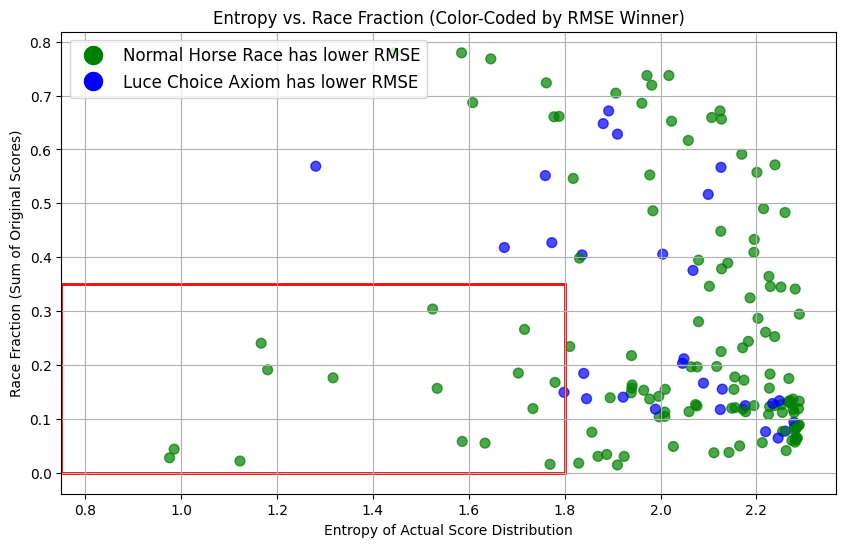

,Question Pair,Entropy,Race Fraction,Color
0,I enjoy board games. My favourite is called [...,1.940221,0.157261,green
1,I enjoy board games. My favourite is called [...,1.965021,0.153092,green
2,I enjoy sports. My favourite is called [MASK]...,2.004615,0.405781,blue
3,I enjoy sports. My favourite is called [MASK]...,1.836407,0.404291,blue
4,I enjoy sports. My favourite is called [MASK]...,2.127175,0.656373,green
...,...,...,...,...
153,"The exercise I enjoy most is called [MASK], a...",1.961174,0.685864,green
154,The news channel I watch is called [MASK]; th...,1.810741,0.234298,green
155,The news channel I watch is called [MASK]; th...,1.939413,0.217410,green
156,The sport that draws the biggest crowds is ca...,2.023026,0.652524,green


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_entropy_vs_race_fraction(df):
    """
    This function generates a scatter plot of race entropy vs. race fraction,
    color-coded by which model has the lower RMSE, and highlights a specific low entropy region.

    Args:
    df (pd.DataFrame): DataFrame containing the columns 'Question Pair', 'Actual score',
                       'Luce RMSE', 'Ability RMSE', and 'Original score'.

    Returns:
    pd.DataFrame: A DataFrame containing the question pair, entropy, race fraction, and color used for plotting.
    """
    # Initialize lists to store entropy, race fractions, colors, and question pairs
    entropies = []
    race_fractions = []
    colors = []
    question_pairs = []

    # Group by 'Question Pair'
    grouped = df.groupby('Question Pair')

    for question_pair, group in grouped:
        # Get the 'Actual score' probabilities
        actual_scores = group['Actual score'].values
        # Ensure that the probabilities sum to 1
        actual_scores = actual_scores / actual_scores.sum()
        # Compute entropy
        entropy = -np.sum(actual_scores * np.log(actual_scores + 1e-10))  # Add small value to avoid log(0)
        # Compute race fraction (sum of 'Original score' column)
        race_fraction = group['Original score'].sum()
        # Get the RMSE values (they should be the same for all rows in the group)
        luce_rmse = group['Luce RMSE'].iloc[0]
        ability_rmse = group['Ability RMSE'].iloc[0]
        # Determine color based on which RMSE is lower
        color = 'green' if ability_rmse < luce_rmse else 'blue'
        # Append to lists
        entropies.append(entropy)
        race_fractions.append(race_fraction)
        colors.append(color)
        question_pairs.append(question_pair)

    # Create scatter plot of Entropy vs Race Fraction
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(entropies, race_fractions, color=colors, s=50, alpha=0.7)

    # Add red box to highlight low entropy region
    ax = plt.gca()
    red_box = patches.Rectangle(
        (0.75, 0),  # Bottom left corner (x, y)
        width=1.05,  # Width of the box (extending to entropy = 1.8)
        height=0.35,  # Height of the box (extending to race fraction = 0.35)
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(red_box)

    # Set x-axis limits to start at 0.75 for entropy
    ax.set_xlim(0.75, ax.get_xlim()[1])

    # Add legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15, label='Normal Horse Race has lower RMSE'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, label='Luce Choice Axiom has lower RMSE')
    ]
    plt.legend(handles=handles, loc='upper left', fontsize=12)

    # Axis labels and title
    plt.xlabel('Entropy of Actual Score Distribution')
    plt.ylabel('Race Fraction (Sum of Original Scores)')
    plt.title('Entropy vs. Race Fraction (Color-Coded by RMSE Winner)')
    plt.grid(True)
    plt.show()

    # Optionally, return the data used for plotting
    return pd.DataFrame({
        'Question Pair': question_pairs,
        'Entropy': entropies,
        'Race Fraction': race_fractions,
        'Color': colors
    })

# Example usage
# plot_entropy_vs_race_fraction(df)


# Example usage
plot_entropy_vs_race_fraction(final_results)
